In [15]:
#import
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from transformers import get_linear_schedule_with_warmup

In [16]:
def data_loading(data_dir):
    data, labels, ids= [], [], []
    df = pd.read_csv(data_dir).loc[:5000]
    data_list = df.loc[:,'discourse_text'].values
    label_list_ = df.loc[:,'discourse_type'].values
    id_list = df.loc[:,'id'].values
    type_dict = {'Lead':1,'Position':2,'Claim':3,'Counterclaim':4,'Rebuttal':5,'Evidence':6,'Concluding Statement':7}
    label_list = []
    for i in label_list_:
        label_list.append(type_dict[i])
    if len(data_list)!=len(label_list):
        return 'length bug'
    n = len(data_list)
    for data_ in range(n):
        sentence_split = data_list[data_].split(".")[:-1] if data_list[data_].split('.')[-1] == str('') else data_list[data_].split(".")
        label_split = [label_list[data_] for i in range(len(sentence_split))]
        id_split = [id_list[data_] for i in range(len(sentence_split))]
        for j in range(len(sentence_split)):
            if sentence_split[j]!=' ':
                data.append(sentence_split[j].lower()) 
                labels.append(label_split[j])
                ids.append(id_split[j])
    data_article, labels_article = [],[]
    data_sentence, labels_sentence = [],[]
    for i in range(len(ids)-1):
        if ids[i]==ids[i+1]: 
            data_sentence.append(data[i])
            labels_sentence.append(labels[i])
        else:
            data_article.append(data_sentence)
            labels_article.append(labels_sentence)
            data_sentence,labels_sentence = [],[]
    return data_article , labels_article


train_data = data_loading('./train.csv')
print('训练集数目：', len(train_data[0]))
#print(train_data[0][0],train_data[1][0])

训练集数目： 534


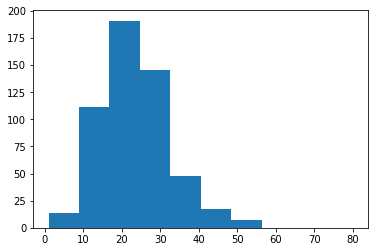

In [17]:
import matplotlib as mlt
plt.hist([len(train_data[1][i]) for i in range(len(train_data[1]))],bins = 10,rwidth=1, range=(1,80))
plt.show()

In [18]:
print(train_data[1][:5])

[[1, 1, 1, 1, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 7], [2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7], [1, 1, 1, 2, 3, 6, 6, 6, 4, 4, 5, 5, 7], [1, 1, 1, 2, 3, 3, 3, 3, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7], [1, 1, 1, 1, 2, 2, 3, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 7]]


In [19]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [20]:
article,labels_ = train_data[0],train_data[1]

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_art = []
attention_masks_art = []
labels = []
# For every sentence...
for art in range(len(article)):
    input_ids_sent = []
    attention_masks_sent = []
    for sent in article[art]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 32,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids_sent.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_sent.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
    input_ids_sent = torch.cat(input_ids_sent, dim=0)
    attention_masks_sent = torch.cat(attention_masks_sent, dim=0)
    labels_sent = torch.tensor(labels_[art])

    input_ids_art.append(input_ids_sent)
    attention_masks_art.append(attention_masks_sent)
    labels.append(labels_sent)

#labels = [label.tolist() for label in labels]

#print('Original: ', article[0])
print('Token IDs:', input_ids_art[:2],labels[:2])
print(attention_masks_art[:2])
#print(labels[2:4])

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Token IDs: [tensor([[  101,  2715,  4286,  2651,  2024,  2467,  2006,  2037,  3042,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2024,  2467,  2006,  2037,  3042,  2062,  2084,  1019,
          2847,  1037,  2154,  2053,  2644,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2035,  2027,  2079,  2003,  3793,  2067,  1998,  2830,  1998,
          2074,  2031,  2177, 11834,  2015,  2006,  2591,  2865,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2130,  2079,  2009,  2096,  4439,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,    

In [73]:
from torch.utils.data import Dataset
class article_dataset(Dataset):
    def __init__(self,input,target,masks):
        super(article_dataset,self).__init__()
        self.input = input
        self.target = target
        self.masks = masks
    def __getitem__(self,idx):
        return self.input[idx],self.masks[idx],self.target[idx]
    def __len__(self):
        return len(self.input)

文章中句子个数不一致问题暂定解决办法：
    1：找到合适的sentence_num（尽量所有文章的长度均小于该值）。
    2：对小于该长度的文章，在处理完tokenizer之前进行空句子补齐，并记录其有效长度。（其会在tokennizer阶段被标注为[101,102,...,0]）。
    3：所有用于补齐的空句子不设置类别，在处理空句子时记录每篇文章的有效句子长度。句子有效长度在每一个batch中使用一个list储存（想办法在dataset中实现）
    4：在模型框架中，仅输出有效句子的损失并进行后向传播。


In [76]:
dataset = article_dataset(input_ids_art,labels,attention_masks_art)
dataloder = DataLoader(dataset,batch_size=5,shuffle=True)

In [82]:
import torch.nn as nn
import torch
class HAN(nn.Module):
    def __init__(self,bert_name,hidden_size_rnn,num_layers_rnn,classes,dropout):     #valid_len表示该input中有效的sentence个数
        super(HAN,self).__init__()
        self.bert = BertModel.from_pretrained(bert_name)
        hidden_size_bert = self.bert.config.hidden_size
        self.rnn = nn.LSTM(input_size=hidden_size_bert, hidden_size=hidden_size_rnn, num_layers=num_layers_rnn, bias=True, dropout=dropout,batch_first=True)
        self.outlayer = nn.Linear(hidden_size_rnn,classes)
        self.loss = nn.CrossEntropyLoss()
        self.classes = classes
        
    def forward(self,input_ids,input_masks,valid_len,labels=None):  #input维度 batchsize,num_sentence,sent_len , label维度batchsize,num_sentence,sent_len
        batch_size,sentence_num,sentence_len = input_ids.size(0),input_ids.size(1),input_ids.size(2)
        hidden_size_bert = self.bert.config.hidden_size
        input_ids,input_masks = input_ids.view(-1,sentence_len),input_masks.view(-1,sentence_len)
        out = self.bert(input_ids,input_masks)      #out维度 batchsize*num_sentence,sen_len,hidden_size
        out = out[0][:,0,:]     #out维度 batchsize*num_sentence,hidden_size
        #下面这行有可能会报错！！！
        out = out.view(batch_size,sentence_num,hidden_size_bert)    #out维度转化为batchsize,num_sentence,hidden_size
        self.rnn.flatten_parameters()
        outputs,_ = self.rnn(out)   #outputs维度 batchsize,num_sentence,hidden_size
        outputs = self.outlayer(outputs)    #outputs维度为 batchsize,num_sentence,7
        output = []
        for batch in range(len(outputs)):
            output.append(outputs[batch][0:valid_len[batch],:].tolist())
        if labels is not None:
            loss_output = []
            for i in output:
                for j in i:
                    loss_output.append(j)
            loss_labels = []
            for k in labels:
                for l in k:
                    loss_labels.append(l)
            loss = self.loss(torch.tensor(loss_output),torch.tensor(loss_labels))
            return loss,outputs
        else:
            return 0,outputs
                
        


In [45]:
mask = torch.tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]],
        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]],
        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]])


In [46]:
sentence = torch.tensor([[[  101,  2715,  4286,  2651,  2024,  2467,  2006,  2037,  3042,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2024,  2467,  2006,  2037,  3042,  2062,  2084,  1019,
          2847,  1037,  2154,  2053,  2644,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
     [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
     [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]],
     [[  101,  2035,  2027,  2079,  2003,  3793,  2067,  1998,  2830,  1998,
          2074,  2031,  2177, 11834,  2015,  2006,  2591,  2865,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2130,  2079,  2009,  2096,  4439,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2027,  2024,  2070,  2428,  2919,  8465,  2043,  4933,  6433,
          2043,  2009,  3310,  2000,  1037,  3042,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
          [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
     [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
     [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]],
     [[  101,  2070,  3056,  2752,  1999,  1996,  2142,  2163,  7221, 11640,
          2013,  2465,  4734,  2074,  2138,  1997,  2009,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2043,  2111,  2031, 11640,  1010,  2027,  2113,  2055,  3056,
         18726,  2008,  2027,  2031,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101, 18726,  2066,  9130, 10474, 16021, 23091,  1998, 10245,  7507,
          2102,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  2061,  2066,  2065,  1037,  2767,  5829,  2185,  1998,  2017,
          2215,  2000,  2022,  1999,  3967,  2017,  2064,  2145,  2022,  1999,
          3967,  2011, 14739,  6876,  2030,  3793,  7696,   102,     0,     0,
             0,     0],
        [  101,  2111,  2467,  2031,  2367,  3971,  2129,  2000, 10639,  2007,
          1037,  3042,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]])


In [59]:
input_id = sentence
input_mask = mask
labels = torch.tensor([[2,3,0,0,0,0],[5,3,2,0,0,0],[5,5,5,2,6,0]])

In [84]:
model = HAN('bert-base-uncased',1024,2,7,0.1)
output = model(input_id,input_mask,[2,3,5],labels=[[2,3],[5,3,2],[5,5,5,2,6]])
print(output)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(tensor(1.9443), tensor([[[ 0.0065, -0.0253, -0.0229,  0.0220, -0.0272, -0.0076, -0.0156],
         [ 0.0135, -0.0305, -0.0271,  0.0293, -0.0308, -0.0082, -0.0203],
         [ 0.0082, -0.0228, -0.0206,  0.0300, -0.0287, -0.0163, -0.0117],
         [ 0.0044, -0.0177, -0.0077,  0.0377, -0.0236, -0.0176, -0.0088],
         [-0.0058, -0.0121, -0.0002,  0.0362, -0.0278, -0.0175, -0.0076],
         [-0.0045, -0.0149,  0.0025,  0.0388, -0.0260, -0.0227, -0.0032]],

        [[-0.0003, -0.0308, -0.0237,  0.0228, -0.0275, -0.0110, -0.0130],
         [ 0.0086, -0.0332, -0.0306,  0.0235, -0.0263, -0.0092, -0.0180],
         [ 0.0155, -0.0344, -0.0310,  0.0201, -0.0234, -0.0093, -0.0175],
         [ 0.0145, -0.0270, -0.0201,  0.0195, -0.0278, -0.0145, -0.0137],
         [ 0.0021, -0.0224, -0.0057,  0.0252, -0.0273, -0.0116, -0.0151],
         [-0.0040, -0.0193,  0.0030,  0.0293, -0.0294, -0.0218, -0.0048]],

        [[ 0.0043, -0.0240, -0.0270,  0.0223, -0.0277, -0.0081, -0.0131],
         [ 0.0170